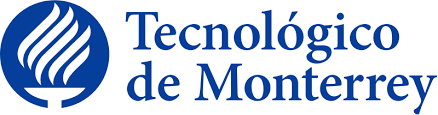

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey
###Asesor: Luis Eduardo Falcón Morales
## **Generación de Comentarios**
###**Equipo 18:**
###**A01793052 - Juan Carlos Lopez Cruz**


# **Comments Generation**


The following Code will generate comments with a previus Fine tuning of GPT2 base model.



# **Libraries to install**

In [ ]:
!pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00


# **Libraries to be used**

In [ ]:
import torch

## Library for Datasets manipulation
from datasets import Dataset, load_dataset, DatasetDict

## Libraries to manipulate and plot data.
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Libraries for Transformer Data Generation and Text Clasiffication.
from evaluate import evaluator
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments,LineByLineTextDataset
from datasets import Dataset, load_dataset, DatasetDict, load_metric

#Library necesary to publish Transformer fine tunning.
from huggingface_hub import notebook_login

# **Load Data from Github**

 Data previusly extracted with Webscrapping program

In [ ]:
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments.csv'
data= pd.read_csv(url)
data

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
1658,After reading about sudden accelerations in Je...,NaN
1659,My 2002 Jeep Grand Cherokee Limited takes off ...,NaN
1660,As I was braking at a stoplight my 2000 Jeep G...,NaN
1661,About 1 1/2 months ago my wife complained to m...,NaN


# **EDA - Exploratory Data Analysis**

## **1- Elimination of nan rows.**

Since in the data extraction some reviews no rated, in these reviews the label was added **nan** , the first thing we must do is eliminate the data that does not have a label.

In [ ]:
nan_data = data.isna()
print(nan_data)

      Review  Stars
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
1658   False   True
1659   False   True
1660   False   True
1661   False   True
1662   False   True

[1663 rows x 2 columns]


In [ ]:
data_clean= data.dropna(subset=['Stars']) # dropna will eliminate nan reviews. (reviews not rated)
data_clean=data_clean.reset_index(drop=True) #restar index
data_clean

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,1.0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,1.0
961,"I purchased a 2011 Grand Cherokee in July, 201...",2.0
962,I have a 2003 Jeep Grand Cherokee and have had...,1.0


## **2- Creation of binary label.**

Convert the rates scale (1,2,3,4,5) to binary problem (0,1)

**Justification:**

When it comes to converting scores from a multi-class classification problem to a binary problem, there are different approaches that can be taken. A common way to approach this situation is to set a threshold to divide ratings into positive and negative.

In this case, if you want to consider ratings between 3 and 4 as 3.5, it is possible to set a threshold at 3.5 to classify the ratings as positive or negative. Any rating equal to or greater than 3.5 would be considered positive, while any rating below 3.5 would be considered negative.

This choice is based on the assumption that a rating of 3.5 is somewhere between positive ratings (greater than 3.5) and negative ratings (less than 3.5). By considering the rating of 3.5 as positive, it is being assumed that comments with a rating close to 3.5 still contain positive elements and should therefore be treated as such.

However, it is important to note that the choice of threshold may depend on the specific context and requirements of the problem. In some cases, it may be more appropriate to adjust the threshold to classify ratings between 3 and 4 as positive or negative. This will depend on the distribution of ratings and how the concept of "positive" and "negative" is defined in the context of the problem at hand. In our case let's decide to consider ratings greater than or equal to 4 as positive and those less than 4 as negative.

In [ ]:
ds = Dataset.from_dict({"text": data_clean.Review, "labels": [1 if star >= 4 else 0 for star in data_clean.Stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 964
})

In [ ]:
ds.to_pandas()

,text,labels
0,Everything with them is 24 to 48 hours and eve...,0
1,So I went in to replace the hose radiator outl...,0
2,I was so excited to buy a Jeep but turns out i...,0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,0
4,I’m a mail carrier from the Dakotas.. so I pur...,0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,0
961,"I purchased a 2011 Grand Cherokee in July, 201...",0
962,I have a 2003 Jeep Grand Cherokee and have had...,0


# **Data Split for Train and Val.**

In [ ]:
def split_dataset(ds):

    ds = ds.class_encode_column ('labels')

    train_test_valid = ds.train_test_split(test_size=0.2, seed=42, stratify_by_column='labels')


    test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed = 42, stratify_by_column='labels')


    return DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
ds_split = split_dataset(ds)
ds_split

Stringifying the column:   0%|          | 0/964 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/964 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 771
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 97
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 96
    })
})

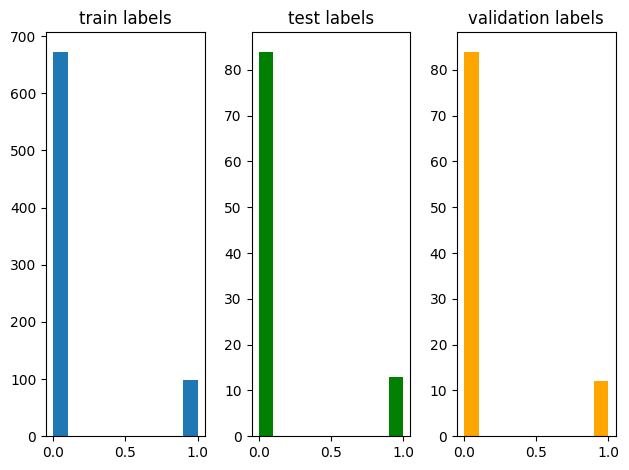

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(ds_split['train']['labels'])
ax2.set_title('test labels')
ax2.hist(ds_split['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(ds_split['valid']['labels'],color='orange')
fig.tight_layout()

# <font color='red'> **Data Augmentation (Text Generation)**

## **1- Creation of coype of data set to add the augmented Data.**

In [ ]:
ds_aug_split=ds_split.map()

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

In [ ]:
ds_aug_split

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 771
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 97
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 96
    })
})

## **2-Filter positive and Negative comments**.

In [ ]:
labels_1 = ds_aug_split['train'].to_pandas()[ds_aug_split['train'].to_pandas().labels== 1]
labels_0 = ds_aug_split['train'].to_pandas()[ds_aug_split['train'].to_pandas().labels== 0]

In [ ]:
labels_1

,text,labels
0,Awesome. I love my Jeep Wrangler very much. It...,1
3,I ordered a Trackhawk when they became availab...,1
5,Handles well and is solid. I have a liberty li...,1
6,I love my Jeep. My overall experience with my ...,1
31,I currently own two Jeep vehicles. One I purch...,1
...,...,...
742,"Decent SUV, nice features, Jeep is usually alw...",1
743,I bought my Jeep Patriot new off the lot. In f...,1
746,The Wrangler handles fantastic in all kinds of...,1
763,My 2006 Jeep Commander is nice and big with 3r...,1


In [ ]:
labels_0

,text,labels
1,Problems with new 2014 Jeep Grand Cherokee - T...,0
2,We have a 2010 Grand Cherokee Limited Hemi and...,0
4,I bought a 2007 Jeep Wrangler about 2 years ag...,0
7,I purchased my Jeep Wrangler Sport less than a...,0
8,My 2010 Jeep Wrangler had four active recalls ...,0
...,...,...
765,Purchased a 2014 Jeep Grand Cherokee and in le...,0
767,I recently purchased a used 2007 Jeep Commande...,0
768,My 2005 Jeep Grand Cherokee with a Hemi engine...,0
769,Jeep Grand Cherokee 2008 Paint Peeling - The p...,0


## **3-Text Generation**

### **Fine tunning (Train GPT-2 model with training data)**

#### **1- Load model for text generation**

In [ ]:
# Load the model and tokenizer
model_name = "openai-community/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

#### **2- Load model to device**

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device(torch.cuda.current_device())
    else:
        return torch.device('cpu')

In [ ]:
get_device()

device(type='cuda', index=0)

#### **3-Tokenize and Test data preparation**.

To train Text Generation GPT-2 we must introduce train data as TextDataset.
Data shoul be enter in the TextDataset as .txt file.

In [ ]:
import tempfile
# Create a temporary file and write the texts in it
with tempfile.NamedTemporaryFile("w", delete=False) as tmp:
    for text in ds_split['train'].to_pandas().text:
        tmp.write(text + "\n")

In [ ]:
# Create the text data set from the temporary file
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=tmp.name,  # Use temporary file name
    block_size=128  # Maximum sequence size
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


#### **4- Create a DataCollector.**

The main purpose of a DataCollator is to batch together multiple data examples into a single batch that the language model can efficiently process during training.

For language modeling tasks, this involves taking variable-length sequences of text and adjusting them so that they all have the same length by padding with special padding tokens if necessary

In [ ]:
# Create data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False #masked language modeling (MLM) model is not applied
)

#### **5-Repository name**

In [ ]:
repo_name = "finetuning-gpt2-finetunned"

#### **6-Train Parameter definition**

In [ ]:
# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir=repo_name,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2)

#### **7- Trainer Definition and Training.**

In [ ]:
# Crear el Trainer y finetune el modelo
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=468, training_loss=3.046029115334535, metrics={'train_runtime': 140.1486, 'train_samples_per_second': 26.693, 'train_steps_per_second': 3.339, 'total_flos': 244373372928000.0, 'train_loss': 3.046029115334535, 'epoch': 3.0})

#### **8-Publish transformer fine tunning**

In [ ]:
notebook_login()

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1709181086.af20e48d4f89.247.0:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1709181525.af20e48d4f89.247.1:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/JC9027/finetuning-gpt2-finetunned/commit/11eef24353f341121d19cd62b8362bde669b53da', commit_message='End of training', commit_description='', oid='11eef24353f341121d19cd62b8362bde669b53da', pr_url=None, pr_revision=None, pr_num=None)

### **Data Generation with Fine tunning model.**

In [ ]:
#Function to generate comments.
def gen_data(prompt,num):
  gen_comments=[]
  for _ in range(num):
    for comment in prompt:
      comments_generated = generator(
          comment,
          #max_length=500,
          do_sample=True,
          num_return_sequences = 1,
          max_new_tokens=100,  # Qty Maximum of tokens to be added in the comment
          temperature=0.5)  #Latency to create text.
      gen_comments.extend(comments_generated)
  return gen_comments

In [ ]:
#fine_tuned_model_name = "/content/finetuning-gpt2-finetunned"  # Path to the directory where you saved the fine-tuned model (Local)
model_name = "openai-community/gpt2"
fine_tuned_model_name = "JC9027/finetuning-gpt2-finetunned" # Model published in hugging face
fine_tuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
generator= pipeline("text-generation", model="JC9027/finetuning-gpt2-finetunned")

Positive_promp=["Jeep vehicle is a great car","I love jeep car","My jeep car is the best", "I really enjoy jeep cars", "I will buy another jeep car again"]
Negative_promp=["Jeep vehicle is the worse car","I do not like jeep car","My jeep car is bad", "I will never buy again a jeep car"]

tokenizer_config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [ ]:
# Generar comentarios positivos y negativos
num_neg_comments = 5 # generate # comments per positive_prompt total 400 comments
num_pos_comments = 80 # generate # comment per negative_prompt
positive_comments = gen_data(Positive_promp,num_pos_comments)
negative_comments = gen_data(Negative_promp,num_neg_comments)


In [ ]:
positive_comments = [comment['generated_text'] for comment in positive_comments]
negative_comments = [comment['generated_text'] for comment in negative_comments]

In [ ]:
positive_labels=np.ones(len(positive_comments)).astype(int).tolist()
negative_labels=np.zeros(len(negative_comments)).astype(int).tolist()

In [ ]:
ds_pos=pd.DataFrame({"text":positive_comments,"labels":positive_labels})
ds_neg=pd.DataFrame({"text":negative_comments,"labels":negative_labels})

## **4- Creation of DataFrame and Storage in a file (Possitive and negative comments)**

In [ ]:
ds_gen = pd.concat([ds_pos, ds_neg])

In [ ]:
ds_gen.to_csv('Jeep_synthetic_comments.csv', index=False,encoding = 'utf8')
files.download('Jeep_synthetic_comments.csv')

# **References:**

- Hugging Face. (n.d.). Trainer — transformers 4.15.0 documentation. Retrieved from https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/trainer#trainer

- Hugging Face. (s.f.). Transformers: Training & Fine-Tuning. Recuperado de https://huggingface.co/docs/transformers/training

- Hugging Face. (s.f.). Text generation strategies. En Hugging Face Transformers Documentation. Recuperado de https://huggingface.co/docs/transformers/en/generation_strategies#diverse-beam-search-decoding